In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import itertools
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.patches as mpatches

np.random.seed(500)

Using TensorFlow backend.


In [3]:
data = pd.read_csv('train.csv',encoding='latin-1')
data.columns=['sentenceID', 'wordID', 'word']
data.head()

,sentenceID,wordID,word
0,0,2,voujm
1,0,3,kvspoh
2,0,4,qpjou
3,0,5,dsbaz
4,0,6,bwbjmbcmf


In [4]:
data.tail()

,sentenceID,wordID,word
90100,5571,2,jut
90101,5571,3,usvf
90102,5571,4,up
90103,5571,5,jut
90104,5571,6,obnf


In [5]:
data.describe()

,sentenceID,wordID
count,90105.000000,90105.000000
mean,2762.466889,12.872682
std,1611.318741,12.819159
min,0.000000,1.000000
25%,1372.000000,5.000000
50%,2748.000000,10.000000
75%,4167.000000,18.000000
max,5571.000000,190.000000


In [6]:
# checking the raw data characteristics
size = data.size 
shape = data.shape 
df_ndim = data.ndim 
series_ndim = data["wordID"].ndim 

print("Size = {}\nShape ={}\nShape[0] x Shape[1] = {}". 
format(size, shape, shape[0]*shape[1])) 

print("ndim of dataframe = {}\nndim of series ={}". 
format(df_ndim, series_ndim))

Size = 270315
Shape =(90105, 3)
Shape[0] x Shape[1] = 270315
ndim of dataframe = 2
ndim of series =1


In [7]:
newdata = data.groupby('sentenceID').apply(lambda x: x['word'].values.tolist())
newdata.head()

sentenceID
0    [voujm, kvspoh, qpjou, dsbaz, bwbjmbcmf, pomz,...
1                       [pl, mbs, kpljoh, xjg, v, poj]
2    [gsff, fousz, jo, 2, b, xlmz, dpnq, up, xjo, g...
3    [v, evo, tbz, tp, fbsmz, ips, v, d, bmsfbez, u...
4    [obi, j, epo, u, uijol, if, hpft, up, vtg, if,...
dtype: object

In [8]:
newdata2 = pd.DataFrame(newdata.apply(lambda x:' '.join(x)).reset_index())
newdata2.columns = ["sentenceID","text"]
newdata2.head()

,sentenceID,text
0,0,voujm kvspoh qpjou dsbaz bwbjmbcmf pomz jo cvh...
1,1,pl mbs kpljoh xjg v poj
2,2,gsff fousz jo 2 b xlmz dpnq up xjo gb dvq gjob...
3,3,v evo tbz tp fbsmz ips v d bmsfbez uifo tbz
4,4,obi j epo u uijol if hpft up vtg if mjwft bspv...


In [9]:
#Using regular expressions to clean the data
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

newdata2 = standardize_text(newdata2, "text")

newdata2.to_csv("cleandata.csv")
newdata2.head()

,sentenceID,text
0,0,voujm kvspoh qpjou dsbaz bwbjmbcmf pomz jo cvh...
1,1,pl mbs kpljoh xjg v poj
2,2,gsff fousz jo 2 b xlmz dpnq up xjo gb dvq gjob...
3,3,v evo tbz tp fbsmz ips v d bmsfbez uifo tbz
4,4,obi j epo u uijol if hpft up vtg if mjwft bspv...


In [10]:
cleandata = pd.read_csv("cleandata.csv")
cleandata.columns=['oldIndex','sentenceID','text']
cleandata.head()

,oldIndex,sentenceID,text
0,0,0,voujm kvspoh qpjou dsbaz bwbjmbcmf pomz jo cvh...
1,1,1,pl mbs kpljoh xjg v poj
2,2,2,gsff fousz jo 2 b xlmz dpnq up xjo gb dvq gjob...
3,3,3,v evo tbz tp fbsmz ips v d bmsfbez uifo tbz
4,4,4,obi j epo u uijol if hpft up vtg if mjwft bspv...


In [11]:
tokenizer = RegexpTokenizer(r'\w+')
cleandata["tokens"] = cleandata["text"].apply(tokenizer.tokenize)
cleandata.head()

,oldIndex,sentenceID,text,tokens
0,0,0,voujm kvspoh qpjou dsbaz bwbjmbcmf pomz jo cvh...,"[voujm, kvspoh, qpjou, dsbaz, bwbjmbcmf, pomz,..."
1,1,1,pl mbs kpljoh xjg v poj,"[pl, mbs, kpljoh, xjg, v, poj]"
2,2,2,gsff fousz jo 2 b xlmz dpnq up xjo gb dvq gjob...,"[gsff, fousz, jo, 2, b, xlmz, dpnq, up, xjo, g..."
3,3,3,v evo tbz tp fbsmz ips v d bmsfbez uifo tbz,"[v, evo, tbz, tp, fbsmz, ips, v, d, bmsfbez, u..."
4,4,4,obi j epo u uijol if hpft up vtg if mjwft bspv...,"[obi, j, epo, u, uijol, if, hpft, up, vtg, if,..."


In [12]:
# checking the cleandata characteristics
size = cleandata.size 
shape = cleandata.shape 
df_ndim = cleandata.ndim 
series_ndim = cleandata["tokens"].ndim 

print("Size = {}\nShape ={}\nShape[0] x Shape[1] = {}". 
format(size, shape, shape[0]*shape[1])) 

print("ndim of dataframe = {}\nndim of series ={}". 
format(df_ndim, series_ndim))

Size = 22280
Shape =(5570, 4)
Shape[0] x Shape[1] = 22280
ndim of dataframe = 2
ndim of series =1


In [13]:
#Checking the inconsistencies between the sentence numbers and the index
cleandata.describe()
#there are two missing comments

,oldIndex,sentenceID
count,5570.000000,5570.000000
mean,2784.500000,2785.028725
std,1608.064831,1608.680164
min,0.000000,0.000000
25%,1392.250000,1392.250000
50%,2784.500000,2784.500000
75%,4176.750000,4177.750000
max,5569.000000,5571.000000


In [14]:
cleandata[cleandata.oldIndex != cleandata.sentenceID]

,oldIndex,sentenceID,text,tokens
3374,3374,3375,hppe bgufsopo nz mpwf ipx bsf upebz j ipqf zpv...,"[hppe, bgufsopo, nz, mpwf, ipx, bsf, upebz, j,..."
3375,3375,3376,zvq xvo cfmjfwf xbu v sfbmmz ofwb d f nth j tf...,"[zvq, xvo, cfmjfwf, xbu, v, sfbmmz, ofwb, d, f..."
3376,3376,3377,ipxt uibu xbudi sftjajoh,"[ipxt, uibu, xbudi, sftjajoh]"
3377,3377,3378,efbs vnnb tif dbmmfe nf opx,"[efbs, vnnb, tif, dbmmfe, nf, opx]"
3378,3378,3379,kvtu gjojtife njttjoh zpv qmfouz,"[kvtu, gjojtife, njttjoh, zpv, qmfouz]"
3379,3379,3380,dpnqmjnfoubsz 4 tubs jcjab ipmjebz ps 10 000...,"[dpnqmjnfoubsz, 4, tubs, jcjab, ipmjebz, ps, 1..."
3380,3380,3381,xfmm j nfbou bt pqqptfe up nz esvolfo ojhiu pg...,"[xfmm, j, nfbou, bt, pqqptfe, up, nz, esvolfo,..."
3381,3381,3382,l nvtu cppl b opu ivi tp hpjoh gps zphb cbtjd ...,"[l, nvtu, cppl, b, opu, ivi, tp, hpjoh, gps, z..."
3382,3382,3383,gsff nth xf cjmmfe zpvs npcjmf ovncfs cz njtub...,"[gsff, nth, xf, cjmmfe, zpvs, npcjmf, ovncfs, ..."
3383,3383,3384,pl dbo,"[pl, dbo]"


In [15]:
#finding the non-matching values or missing sentences
cleandata[~cleandata.oldIndex.isin(cleandata.sentenceID)]

,oldIndex,sentenceID,text,tokens
3374,3374,3375,hppe bgufsopo nz mpwf ipx bsf upebz j ipqf zpv...,"[hppe, bgufsopo, nz, mpwf, ipx, bsf, upebz, j,..."
4822,4822,4824,j bn hpjoh up tmffq j bn ujsfe pg usbwfm,"[j, bn, hpjoh, up, tmffq, j, bn, ujsfe, pg, us..."


In [16]:
#Loading the file with the targes or labels
target = pd.read_csv("labels_Candidate.csv",header=None,na_filter=False)
target.columns = ['sentenceID','label']
target.tail()

,sentenceID,label
5567,5567,
5568,5568,
5569,5569,
5570,5570,
5571,5571,


In [17]:
target.sentenceID.index

RangeIndex(start=0, stop=5572, step=1)

In [18]:
#Taking care of first missing value 
target=target.drop([3374],axis=0)
target[3370:3381]

,sentenceID,label
3370,3370,0
3371,3371,0
3372,3372,0
3373,3373,0
3375,3375,0
3376,3376,0
3377,3377,0
3378,3378,0
3379,3379,0
3380,3380,1


In [19]:
#Taking care of second missing value 
target=target.drop([4822],axis=0)
target[4820:4831]

,sentenceID,label
4821,4821,
4823,4823,
4824,4824,
4825,4825,
4826,4826,
4827,4827,
4828,4828,
4829,4829,
4830,4830,
4831,4831,


In [20]:
completedata = pd.merge(cleandata,target,on='sentenceID')
completedata.tail()

,oldIndex,sentenceID,text,tokens,label
5565,5565,5567,uijt jt uif 2oe ujnf xf ibwf usjfe 2 dpoubdu v...,"[uijt, jt, uif, 2oe, ujnf, xf, ibwf, usjfe, 2,...",
5566,5566,5568,xjmm _ c hpjoh up ftqmbobef gs ipnf,"[xjmm, _, c, hpjoh, up, ftqmbobef, gs, ipnf]",
5567,5567,5569,qjuz xbt jo nppe gps uibu tp boz puifs tvhhftu...,"[qjuz, xbt, jo, nppe, gps, uibu, tp, boz, puif...",
5568,5568,5570,uif hvz eje tpnf cjudijoh cvu j bdufe mjlf j e...,"[uif, hvz, eje, tpnf, cjudijoh, cvu, j, bdufe,...",
5569,5569,5571,spgm jut usvf up jut obnf,"[spgm, jut, usvf, up, jut, obnf]",


In [21]:
#Data inspection
all_words = [word for tokens in completedata["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in completedata["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

89734 words total, with a vocabulary size of 8662
Max sentence length is 190


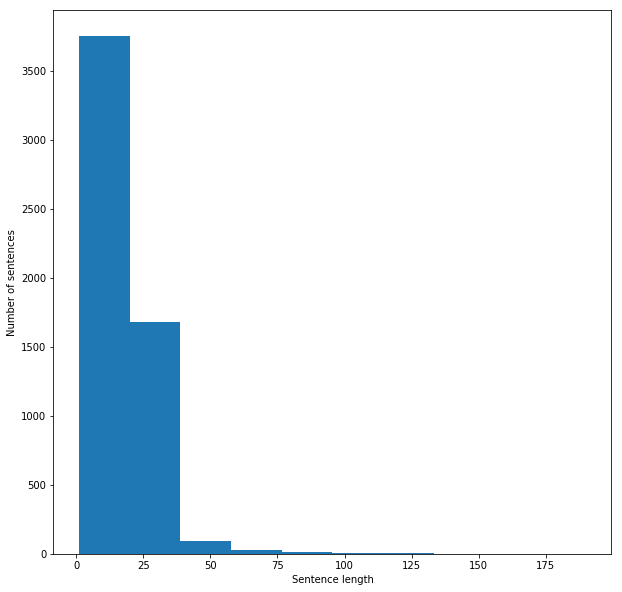

In [22]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [23]:
#Checking class imbalance, I will gert back to this later
completedata.groupby("label").count()

,oldIndex,sentenceID,text,tokens
label,,,,
,1571,1571,1571,1571
0,3464,3464,3464,3464
1,535,535,535,535


In [24]:
completedata.label.value_counts()

0    3464
     1571
1     535
Name: label, dtype: int64

In [25]:
#Extracting training-validation data
train_valid_set=completedata[:3999]
train_valid_set.tail()

,oldIndex,sentenceID,text,tokens,label
3994,3994,3995,xf mm zpv qbz pwfs mjlf mu hu zst tp jut opu u...,"[xf, mm, zpv, qbz, pwfs, mjlf, mu, hu, zst, tp...",0
3995,3995,3996,cpsfe ipvtfxjwft dibu o ebuf opx 0871750 77 11...,"[cpsfe, ipvtfxjwft, dibu, o, ebuf, opx, 087175...",1
3996,3996,3997,xf usjfe up dbmm zpv sf zpvs sfqmz up pvs tnt ...,"[xf, usjfe, up, dbmm, zpv, sf, zpvs, sfqmz, up...",1
3997,3997,3998,l l xifo xjmm zpv hjwf usfbu,"[l, l, xifo, xjmm, zpv, hjwf, usfbu]",0
3998,3998,3999,uijt jt uif 2oe ujnf xf ibwf usjfe up dpoubdu ...,"[uijt, jt, uif, 2oe, ujnf, xf, ibwf, usjfe, up...",1


In [26]:
#Extracting test data for prediction of labels later on
test_set=completedata[3999:]
test_set.head()

,oldIndex,sentenceID,text,tokens,label
3999,3999,4000,if t kvtu hpoob xpssz gps opuijoh boe if xpo u...,"[if, t, kvtu, hpoob, xpssz, gps, opuijoh, boe,...",
4000,4000,4001,eje zpv hfu boz hjgu uijt zfbs j ejeou hfu boz...,"[eje, zpv, hfu, boz, hjgu, uijt, zfbs, j, ejeo...",
4001,4001,4002,tpnfxifsf pvu uifsf cfofbui uif qbmf nppo mjhi...,"[tpnfxifsf, pvu, uifsf, cfofbui, uif, qbmf, np...",
4002,4002,4003,xfmm uifsf t b qbuufso fnfshjoh pg nz gsjfoet ...,"[xfmm, uifsf, t, b, qbuufso, fnfshjoh, pg, nz,...",
4003,4003,4004,px v efz j qbje 60 400uipvtbe j upme v xpvme dbmm,"[px, v, efz, j, qbje, 60, 400uipvtbe, j, upme,...",


In [27]:
train_valid_set["label"].value_counts()

0    3464
1     535
Name: label, dtype: int64

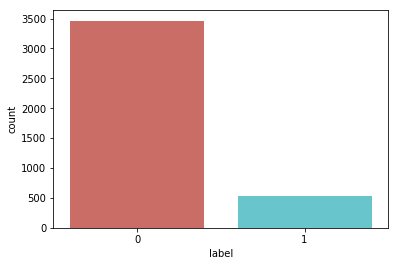

<Figure size 432x288 with 0 Axes>

In [28]:
sns.countplot(x='label', data=train_valid_set, palette='hls')
plt.show()
plt.savefig('label_counts')

In [30]:
#Bag of Word Counts - Feature enginering
#Working only with training-validation data to train model, excludes test data set

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

x_corpus = train_valid_set.text
y_labels = train_valid_set.label

X_train, X_test, y_train, y_test = train_test_split(x_corpus, y_labels, test_size=0.1, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

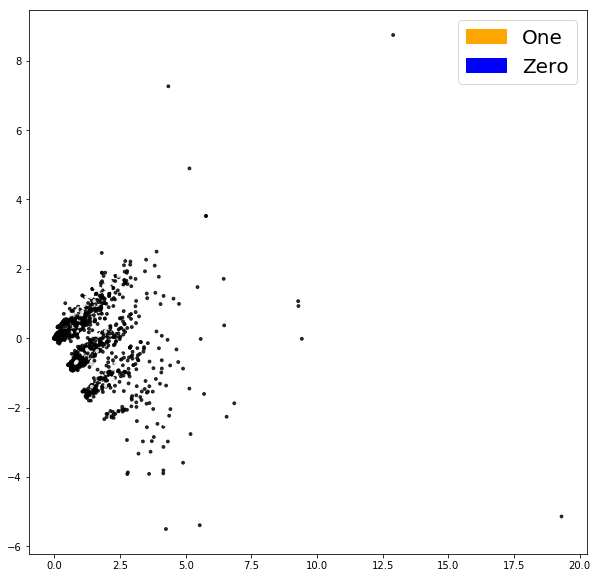

In [31]:
#Vizualazing word embeddings
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='One')
            green_patch = mpatches.Patch(color='blue', label='Zero')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

0.001 score: 0.86802
0.1 score: 0.98416
1 score: 0.99778
10 score: 0.99972
100 score: 1.0
Best c : 100


/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 1.0, 'Inverse of regularization strength in logistic regression ')

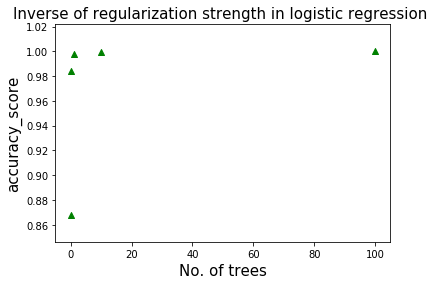

In [32]:
Cs = [0.001, 0.1, 1, 10, 100]
results = []
max_score = 0
for c in Cs:
    clf = LogisticRegression(C=c)
    clf.fit(X_train_counts, y_train)
    score = accuracy_score(clf.predict(X_train_counts),y_train)
    print('{}'.format(c)+ ' score: {:.5}'.format(score))
    results.append(score)
    if (score > max_score):
        max_score = score
        best_c = c

print("Best c : " + str(best_c))
plt.scatter(x=Cs, y= results, marker='^', color='green')
plt.xlabel('No. of trees', fontsize=15)
plt.ylabel('accuracy_score',fontsize=15)
plt.title('Inverse of regularization strength in logistic regression ',fontsize=15)

In [33]:
#Fitting a classifier
#Starting with a logistic regression
# Creating the logistic regression clasifier: clf
clf = LogisticRegression(C=0.001,class_weight='balanced', solver='liblinear', 
                         random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [34]:
#Evaluating the classifier using several metrics
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.897, precision = 0.937, recall = 0.897, f1 = 0.907


In [35]:
#Inspecting the metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)


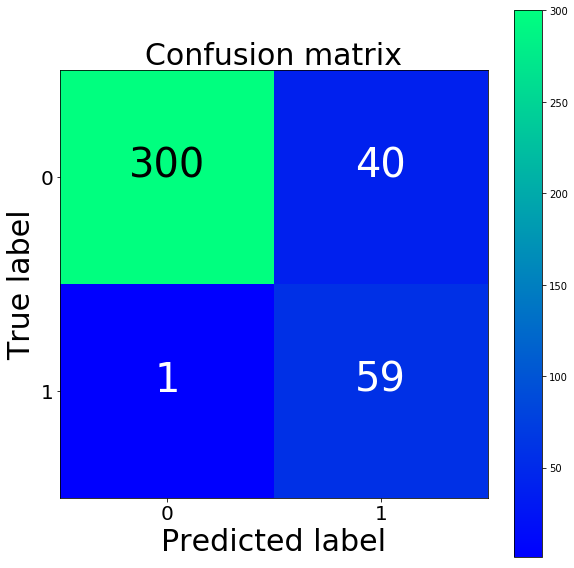

[[300  40]
 [  1  59]]


In [36]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(8, 8))
plot = plot_confusion_matrix(cm, classes=['0','1'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [37]:
#Understanding the first iteration of classifier with using CountVectorizer
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)


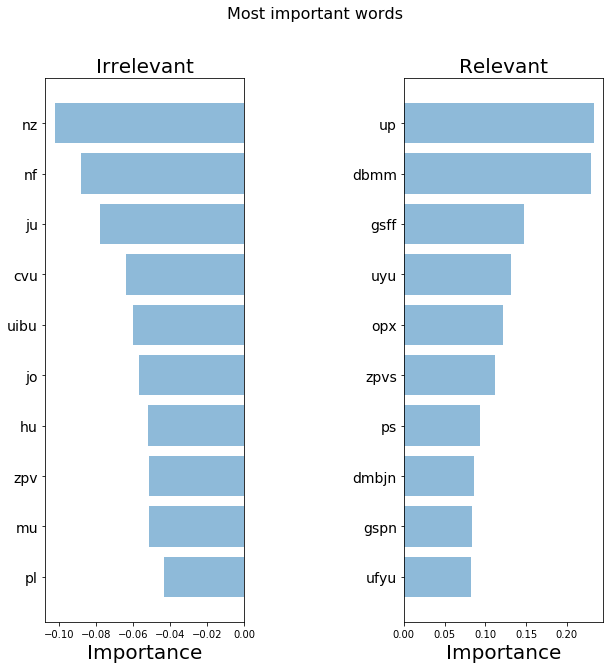

In [38]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Relevant', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

In [39]:
#TFIDF Bag of words

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

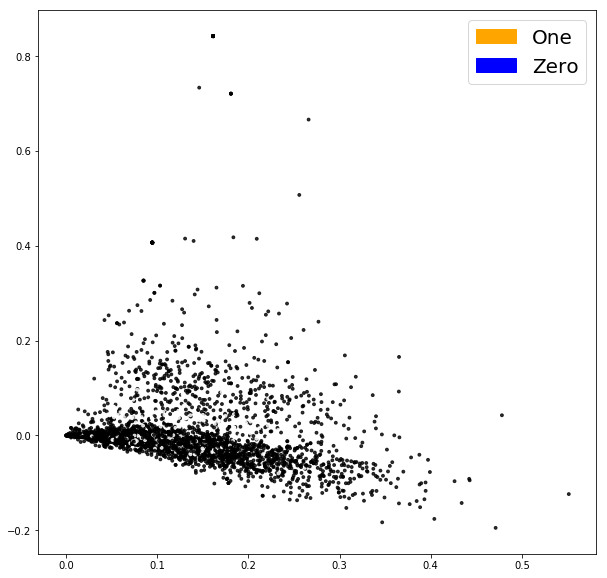

In [40]:

fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show() #this looks much better!

In [41]:
#Fitting logistic regression for TFIDF
clf_tfidf = LogisticRegression(C=0.001, class_weight='balanced', solver='liblinear', 
                         random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [42]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.948, precision = 0.959, recall = 0.948, f1 = 0.950


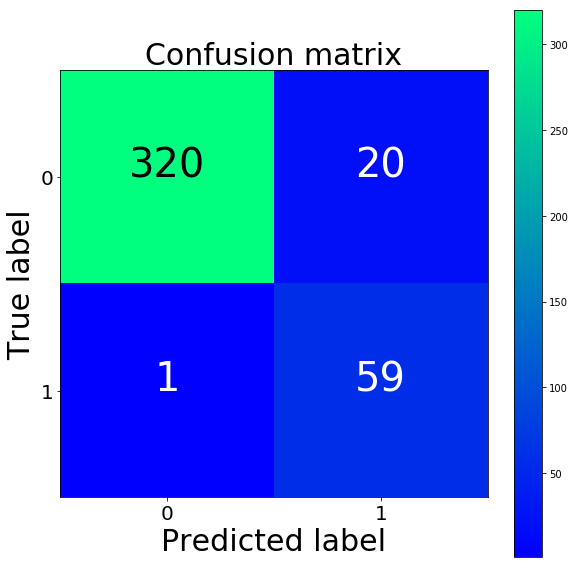

TFIDF confusion matrix
[[320  20]
 [  1  59]]
BoW confusion matrix
[[300  40]
 [  1  59]]


In [43]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(8, 8))
plot = plot_confusion_matrix(cm2, classes=['0','1'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [44]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

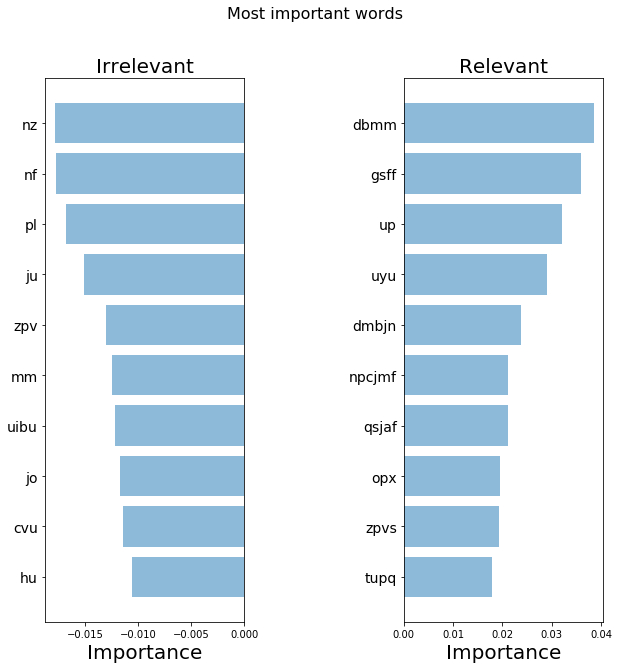

In [45]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

In [50]:
#Predicting the lables for test data: test_data using TFIDF Bag of Words and Logistic Regresion

test_set=completedata[3999:]
X_test_to_predict = test_set.text


In [51]:
def tfidf_pred(data):
    tfidf_vectpred = TfidfVectorizer()

    trainpred = tfidf_vectpred.fit_transform(data)

    return trainpred, tfidf_vectpred

X_train_tfidfpred, tfidf_vectpred = tfidf_pred(X_train)
X_test_labels = tfidf_vectpred.transform(X_test_to_predict)


In [54]:
#Fitting logistic regression for TFIDF
clf_predi = LogisticRegression(C=0.001, class_weight='balanced', solver='liblinear', 
                         random_state=40)

clf_predi.fit(X_train_tfidfpred, y_train)

y_to_pred_labels = clf_predi.predict(X_test_labels)

In [55]:
y_to_pred_labels.shape[0]

1571

In [56]:
test_set.shape[0]

1571

In [57]:
test_set["predicted_labels"] = y_to_pred_labels
test_set.head()

/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,oldIndex,sentenceID,text,tokens,label,predicted_labels
3999,3999,4000,if t kvtu hpoob xpssz gps opuijoh boe if xpo u...,"[if, t, kvtu, hpoob, xpssz, gps, opuijoh, boe,...",,0
4000,4000,4001,eje zpv hfu boz hjgu uijt zfbs j ejeou hfu boz...,"[eje, zpv, hfu, boz, hjgu, uijt, zfbs, j, ejeo...",,0
4001,4001,4002,tpnfxifsf pvu uifsf cfofbui uif qbmf nppo mjhi...,"[tpnfxifsf, pvu, uifsf, cfofbui, uif, qbmf, np...",,0
4002,4002,4003,xfmm uifsf t b qbuufso fnfshjoh pg nz gsjfoet ...,"[xfmm, uifsf, t, b, qbuufso, fnfshjoh, pg, nz,...",,0
4003,4003,4004,px v efz j qbje 60 400uipvtbe j upme v xpvme dbmm,"[px, v, efz, j, qbje, 60, 400uipvtbe, j, upme,...",,1


In [58]:
predicted_labels=test_set.filter(items=['sentenceID','text','tokens','predicted_labels'])
predicted_labels.head()

,sentenceID,text,tokens,predicted_labels
3999,4000,if t kvtu hpoob xpssz gps opuijoh boe if xpo u...,"[if, t, kvtu, hpoob, xpssz, gps, opuijoh, boe,...",0
4000,4001,eje zpv hfu boz hjgu uijt zfbs j ejeou hfu boz...,"[eje, zpv, hfu, boz, hjgu, uijt, zfbs, j, ejeo...",0
4001,4002,tpnfxifsf pvu uifsf cfofbui uif qbmf nppo mjhi...,"[tpnfxifsf, pvu, uifsf, cfofbui, uif, qbmf, np...",0
4002,4003,xfmm uifsf t b qbuufso fnfshjoh pg nz gsjfoet ...,"[xfmm, uifsf, t, b, qbuufso, fnfshjoh, pg, nz,...",0
4003,4004,px v efz j qbje 60 400uipvtbe j upme v xpvme dbmm,"[px, v, efz, j, qbje, 60, 400uipvtbe, j, upme,...",1


In [59]:
predicted_labels.to_csv("Predicted_Labels.csv")